In [1]:
import os
import tweepy as tw
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import collections
import numpy as np
import scipy

import nltk
from nltk.corpus import stopwords
from nltk import bigrams
import re
import networkx as nx
from textblob import TextBlob
from pathlib import Path
from nltk.stem import WordNetLemmatizer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk import FreqDist
from wordcloud import (WordCloud, get_single_color_func)
from textblob import TextBlob


import warnings
warnings.filterwarnings("ignore")

sns.set(font_scale=1.5)
sns.set_style("whitegrid")

##### original code for importing twitter data was taken from https://www.earthdatascience.org/courses/use-data-open-source-python/intro-to-apis/calculate-tweet-word-frequencies-in-python/
###### it contains personal private access keys and tokens, so I didn't put the tweets extraction code here and instead read the tweets I extracted from the file

## read tweets from a file

In [2]:
with open('academia_tweets.txt') as f:
    all_tweets = f.readlines()

In [3]:
def remove_url(txt):
    """Replace URLs found in a text string with nothing 
    (i.e. it will remove the URL from the string).

    Parameters
    ----------
    txt : string
        A text string that you want to parse and remove urls.

    Returns
    -------
    The same txt string with url's removed.
    """

    return " ".join(re.sub("([^0-9A-Za-z \t])|(\w+:\/\/\S+)", "", txt).split())

In [4]:
#removing 'urls' from tweets
all_tweets_no_urls = [remove_url(tweet) for tweet in all_tweets]

## Sentiment analysis (Sentiart and Text Blob)

In [5]:
tokens = [[t.lower() for t in nltk.word_tokenize(tweet) if t.isalpha()] for tweet in all_tweets_no_urls if len(tweet) > 5]
tweets = ". ".join([" ".join(token) for token in tokens]) + '. '

#### Sentiart

In [6]:
TC = Path('250kSentiArt.xlsx') # for English texts
sa = pd.read_excel(TC) 

In [7]:
#function to define sentiart values
def make_sent_means(senti_art, song_tokens):
    """
    estimate mean sentiart values
    
    IMPROVEMENT:
    * keep only nouns
    * other rules
    """

    sent_means = []
    for t in song_tokens:
        dt = senti_art.query('word in @t')

        if len(dt['AAPz'].values) > 0:
            sent_means.append(dt['AAPz'].values[0])

    return np.mean(sent_means)

#### Preparing the data frame for correlation (with text bolb and sentiart values)
###### takes around two minutes to load

In [8]:
%%time
for_corr = pd.DataFrame(columns=['Tweet', 'Blob', 'Sentiart'])
blob = TextBlob(tweets)
all_blob = [str(i) for i in blob.sentences]
    
final_tokens = []
n = 0
for t in tokens:
    sent = " ".join(t)+"."
    if sent in all_blob:
        final_tokens.append(sent)
        for_corr.loc[n, 'Tweet'] = sent
        for_corr.loc[n, 'Blob'] = blob.sentences[all_blob.index(sent)].sentiment.polarity
        for_corr.loc[n, 'Sentiart'] = make_sent_means(sa, t)
        n += 1

CPU times: user 1min 57s, sys: 459 ms, total: 1min 57s
Wall time: 1min 58s


In [9]:
#removing na's
for_corr.fillna(0, inplace=True)

In [10]:
#tweet and sentiart & textblob values
for_corr

,Tweet,Blob,Sentiart
0,real life stories in academia.,0.200000,0.869250
1,let it be said that every time an academic ext...,-0.125000,-0.033333
2,i know academia has its fair share of ills but...,0.650000,0.643591
3,aquicarattino for pis that supervised but dont...,0.230556,0.223289
4,ive heard the clich academia is stuffy cant co...,0.384545,0.238324
...,...,...,...
766,this thread is amazingreally important questio...,0.400000,0.296200
767,wellbeingwhisperer wellbeing selfcare thinking...,0.000000,1.089500
768,kikimancy very plausible hypothesis i returned...,0.100000,-0.197262
769,olimisquitta for sure i moved to the uk to stu...,0.242857,0.033104


#### Correlation between Sentiart and Text Blob: small but significant

In [11]:
scipy.stats.pearsonr(for_corr['Blob'].values, for_corr['Sentiart'].values)

(0.1735909473875577, 1.240099740052545e-06)

### Creating sets of positive and negative words with Sentiart to proceed with wordclouds

In [12]:
tokens = [t for t in nltk.word_tokenize(tweets) if t.isalpha()]
tokens = [token.lower() for token in tokens]

In [13]:
sentiart = sa.iloc[:,:2]

In [14]:
pwords = sentiart.loc[sentiart['AAPz'] > sentiart['AAPz'].to_numpy().mean() + 2*sentiart['AAPz'].to_numpy().std(), 'word'].values
tokfrqp = FreqDist([t for t in tokens if t in pwords])

In [15]:
nwords = sentiart.loc[sentiart['AAPz'] < sentiart['AAPz'].to_numpy().mean() - 2*sentiart['AAPz'].to_numpy().std(), 'word'].values
tokfrqn = FreqDist([t for t in tokens if t in nwords])

## Wordclouds

###### Source&inspiration of GroupedColorFunc class: https://amueller.github.io/word_cloud/auto_examples/colored_by_group.html

In [16]:
class GroupedColorFunc(object):
    """Create a color function object which assigns DIFFERENT SHADES of
       specified colors to certain words based on the color to words mapping.

       Uses wordcloud.get_single_color_func

       Parameters
       ----------
       color_to_words : dict(str -> list(str))
         A dictionary that maps a color to the list of words.

       default_color : str
         Color that will be assigned to a word that's not a member
         of any value from color_to_words.
    """

    def __init__(self, color_to_words, default_color):
        self.color_func_to_words = [
            (get_single_color_func(color), set(words))
            for (color, words) in color_to_words.items()]

        self.default_color_func = get_single_color_func(default_color)

    def get_color_func(self, word):
        """Returns a single_color_func associated with the word"""
        try:
            color_func = next(
                color_func for (color_func, words) in self.color_func_to_words
                if word in words)
        except StopIteration:
            color_func = self.default_color_func

        return color_func

    def __call__(self, word, **kwargs):
        return self.get_color_func(word)(word, **kwargs)

color_to_words = {
    # words below will be colored with a green single color function
    'red': tokfrqp,
    # will be colored with a red single color function
    'blue': tokfrqn
}
default_color = 'grey'
grouped_color_func = GroupedColorFunc(color_to_words, default_color)

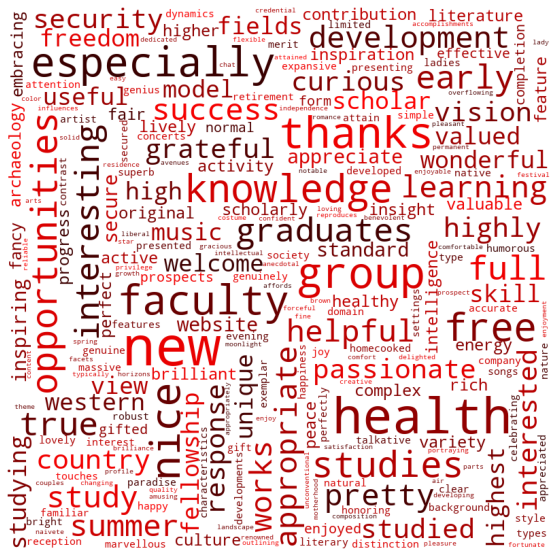

In [17]:
#positive words

wc2 = WordCloud(background_color="white",
                      width=800,
                      height=800,
                      max_words=4000, max_font_size=80, relative_scaling=.5).generate_from_frequencies(tokfrqp)
wc2.recolor(color_func=grouped_color_func)
plt.figure(figsize=(10, 10))
plt.imshow(wc2)
plt.axis("off")
plt.show()

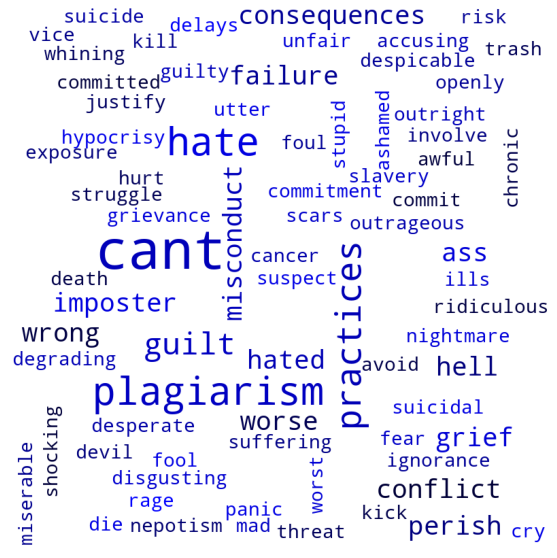

In [18]:
#negative words

wc2 = WordCloud(background_color="white",
                      width=800,
                      height=800,
                      max_words=4000, max_font_size=80, relative_scaling=.5).generate_from_frequencies(tokfrqn)
wc2.recolor(color_func=grouped_color_func)
plt.figure(figsize=(10, 10))
plt.imshow(wc2)
plt.axis("off")
plt.show()